# import all the necessary libraries, set the display options as needed

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn.linear_model import LogisticRegression

pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 25)


# Read the data from the csv file and check if its read correctly

In [2]:
os.chdir(r'C:\Users\tejan\Downloads\creditcardfraud')
data = pd.read_csv("creditcard.csv")

print("The first 5 rows in the dataset are :", "\n", data.head())
print("\n")
print("The shape of the data is :", str(data.shape))


The first 5 rows in the dataset are : 
    Time     V1     V2     V3     V4     V5     V6     V7     V8     V9  ...    V21    V22    V23    V24    V25    V26    V27    V28  Amount  Class
0   0.0 -1.360 -0.073  2.536  1.378 -0.338  0.462  0.240  0.099  0.364  ... -0.018  0.278 -0.110  0.067  0.129 -0.189  0.134 -0.021  149.62      0
1   0.0  1.192  0.266  0.166  0.448  0.060 -0.082 -0.079  0.085 -0.255  ... -0.226 -0.639  0.101 -0.340  0.167  0.126 -0.009  0.015    2.69      0
2   1.0 -1.358 -1.340  1.773  0.380 -0.503  1.800  0.791  0.248 -1.515  ...  0.248  0.772  0.909 -0.689 -0.328 -0.139 -0.055 -0.060  378.66      0
3   1.0 -0.966 -0.185  1.793 -0.863 -0.010  1.247  0.238  0.377 -1.387  ... -0.108  0.005 -0.190 -1.176  0.647 -0.222  0.063  0.061  123.50      0
4   2.0 -1.158  0.878  1.549  0.403 -0.407  0.096  0.593 -0.271  0.818  ... -0.009  0.798 -0.137  0.141 -0.206  0.502  0.219  0.215   69.99      0

[5 rows x 31 columns]


The shape of the data is : (284807, 31)


# Check for the missing values, abnormal values, etc

In [3]:
print("Basic summary statistics of the data :", "\n", data.describe(include = 'all').transpose())
data.isnull().sum()

Basic summary statistics of the data : 
            count       mean        std      min        25%        50%         75%         max
Time    284807.0  9.481e+04  47488.146    0.000  54201.500  84692.000  139320.500  172792.000
V1      284807.0  3.920e-15      1.959  -56.408     -0.920      0.018       1.316       2.455
V2      284807.0  5.688e-16      1.651  -72.716     -0.599      0.065       0.804      22.058
V3      284807.0 -8.769e-15      1.516  -48.326     -0.890      0.180       1.027       9.383
V4      284807.0  2.782e-15      1.416   -5.683     -0.849     -0.020       0.743      16.875
V5      284807.0 -1.553e-15      1.380 -113.743     -0.692     -0.054       0.612      34.802
V6      284807.0  2.011e-15      1.332  -26.161     -0.768     -0.274       0.399      73.302
V7      284807.0 -1.694e-15      1.237  -43.557     -0.554      0.040       0.570     120.589
V8      284807.0 -1.927e-16      1.194  -73.217     -0.209      0.022       0.327      20.007
V9      284807.0 -3

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
         ..
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Length: 31, dtype: int64

# Checking for target variable class imbalance

The class counts of the target variable are : 
    Class  Counts
0      0  284315
1      1     492


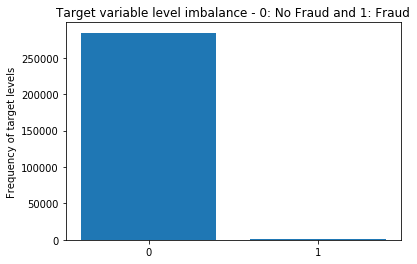

In [4]:
class_counts = data.groupby("Class").size().reset_index(name = "Counts")
print("The class counts of the target variable are :", "\n", class_counts.head())

plt.bar(class_counts['Class'], class_counts['Counts'], align='center')
plt.xticks(class_counts['Class'])
plt.ylabel('Frequency of target levels')
plt.title('Target variable level imbalance - 0: No Fraud and 1: Fraud')
plt.show()

# We have to do a holdout sample for validation of the final model

In [3]:
data_class0 = data[data.Class == 0]
data_class1 = data[data.Class == 1]
data_class0_train, data_class0_test = train_test_split(data_class0, test_size = 0.25,random_state = 12356) 
data_class1_train, data_class1_test = train_test_split(data_class1, test_size = 0.25,random_state = 12356) 

In [4]:
data_train = pd.concat([data_class0_train, data_class1_train], ignore_index = True)
data_test = pd.concat([data_class0_test, data_class1_test], ignore_index = True)

In [5]:
data_train.groupby("Class").size()

Class
0    213236
1       369
dtype: int64

In [8]:
data_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,69286.0,1.176,0.072,-0.737,1.582,2.151,4.121,-0.616,0.986,-0.325,...,-0.122,-0.355,-0.131,1.017,0.777,0.091,0.007,0.017,23.24,0
1,73938.0,-1.356,-0.120,-0.329,-1.971,1.160,-0.438,0.112,0.447,0.547,...,0.180,0.521,-0.589,-1.071,-0.141,-0.769,0.115,-0.150,13.99,0
2,162184.0,1.985,-0.382,-0.280,0.494,-0.721,-0.528,-0.575,-0.078,1.421,...,0.189,0.823,0.096,-0.074,-0.064,-0.207,0.044,-0.037,9.99,0
3,73341.0,1.095,0.080,0.305,1.027,0.009,0.243,-0.014,0.128,-0.015,...,-0.094,-0.203,-0.069,-0.316,0.531,-0.437,0.033,0.012,37.29,0
4,151521.0,0.158,0.147,0.311,-0.457,0.976,-0.583,0.840,-0.394,0.368,...,-0.272,-0.508,0.003,-0.524,-1.091,0.094,-0.365,-0.382,1.98,0


# Removing the Time variable and standardizing the numeric variables, except target variable in the training data

In [6]:
data.drop(['Time'], axis = 1, inplace = True)
data_train.drop(['Time'], axis = 1, inplace = True)
data_test.drop(['Time'], axis = 1, inplace = True)

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = preprocessing.StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# Build 3 separate datasets from training data-
# Random Undersampling of training data, building a logit model, and validation on holdout data
# Random Oversampling of training data, building a logit model, and validation on holdout data
# SMOTETOMEK oversampling of training data, building a logit model, and validation on holdout data

In [7]:
rus = RandomUnderSampler(random_state=123)
X_rus, y_rus = rus.fit_resample(X_train_standardized, y_train)
print('Undersampled training dataset shape %s' % Counter(y_rus))
print('Original training dataset shape %s' % Counter(y_train))
print('Original testing dataset shape %s' % Counter(y_test))

Undersampled training dataset shape Counter({0: 369, 1: 369})
Original training dataset shape Counter({0: 213236, 1: 369})
Original testing dataset shape Counter({0: 71079, 1: 123})


In [8]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=123)
X_ros, y_ros = ros.fit_resample(X_train_standardized, y_train)
print('Oversampled training dataset shape %s' % Counter(y_ros))
print('Original training dataset shape %s' % Counter(y_train))
print('Original testing dataset shape %s' % Counter(y_test))

Oversampled training dataset shape Counter({0: 213236, 1: 213236})
Original training dataset shape Counter({0: 213236, 1: 369})
Original testing dataset shape Counter({0: 71079, 1: 123})


In [9]:
smt = SMOTETomek(random_state=123)
X_smt, y_smt = smt.fit_resample(X_train_standardized, y_train)
print('SmoteTomek dataset shape %s' % Counter(y_smt))
print('Original training dataset shape %s' % Counter(y_train))
print('Original testing dataset shape %s' % Counter(y_test))

SmoteTomek dataset shape Counter({0: 213236, 1: 213236})
Original training dataset shape Counter({0: 213236, 1: 369})
Original testing dataset shape Counter({0: 71079, 1: 123})


# Save the smotetomek upsampled training data and test data as csv files onto the machine

In [10]:
X_cols = list(data.columns.values)
X_cols.remove('Class')
X_smt_df = pd.DataFrame(X_smt, columns = X_cols)
X_smt_df.head()
y_smt_df = pd.DataFrame(y_smt, columns = ['Class'])
y_smt_df.head()
Smote_train = pd.concat([X_smt_df, y_smt_df], axis = 1)
Smote_train.to_csv('SMOTE_TRAIN.CSV')

X_test_df = pd.DataFrame(X_test_standardized, columns = X_cols)
X_test_df.head()
y_test_df = pd.DataFrame(y_test, columns = ['Class'])
y_test_df.head()
test = pd.concat([X_test_df, y_test_df], axis = 1)
test.to_csv('test.CSV')


# 3 models on the 3 differently sampled datasets and validation them on the common test data

# Model1- Undersampled data and validation on test data

In [11]:
clf_rus = LogisticRegression(solver =  'liblinear', penalty = 'l1', random_state=0).fit(X_rus, y_rus)
PREDICTIONS_rus_train = clf_rus.predict(X_rus)
PREDICTIONS_rus_test = clf_rus.predict(X_test_standardized)
print("The accuracy of the Logistic regression model on the Undersampled training data is :", clf_rus.score(X_rus, y_rus))
print("The accuracy of the Logistic regression model on the test data is :", clf_rus.score(X_test_standardized, y_test))

The accuracy of the Logistic regression model on the Undersampled training data is : 0.9552845528455285
The accuracy of the Logistic regression model on the test data is : 0.9532878289935676


In [12]:
cm_rus_train = metrics.confusion_matrix(y_rus, PREDICTIONS_rus_train)
print("The confusion matrix of training data is :", "\n", cm_rus_train)
cm_rus_test = metrics.confusion_matrix(y_test, PREDICTIONS_rus_test)
print("The confusion matrix of test data is :", "\n", cm_rus_test)

The confusion matrix of training data is : 
 [[365   4]
 [ 29 340]]
The confusion matrix of test data is : 
 [[67761  3318]
 [    8   115]]


In [13]:
print("The classification report on training data is \n")
print(classification_report(y_rus, PREDICTIONS_rus_train))
print("The classification report on test data is \n")
print(classification_report(y_test, PREDICTIONS_rus_test))

The classification report on training data is 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       369
           1       0.99      0.92      0.95       369

    accuracy                           0.96       738
   macro avg       0.96      0.96      0.96       738
weighted avg       0.96      0.96      0.96       738

The classification report on test data is 

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     71079
           1       0.03      0.93      0.06       123

    accuracy                           0.95     71202
   macro avg       0.52      0.94      0.52     71202
weighted avg       1.00      0.95      0.97     71202



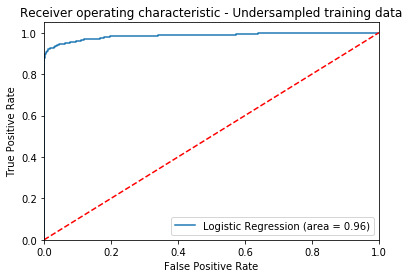

<Figure size 432x288 with 0 Axes>

In [14]:
logit_roc_auc = roc_auc_score(y_rus, clf_rus.predict(X_rus))
fpr, tpr, thresholds = roc_curve(y_rus, clf_rus.predict_proba(X_rus)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Undersampled training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

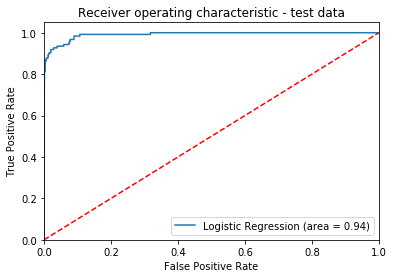

<Figure size 432x288 with 0 Axes>

In [15]:
logit_roc_auc = roc_auc_score(y_test, clf_rus.predict(X_test_standardized))
fpr, tpr, thresholds = roc_curve(y_test, clf_rus.predict_proba(X_test_standardized)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - test data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

# Model2- Oversampled data and validation on test data


In [16]:
clf_ros = LogisticRegression(solver = 'saga', penalty = 'l2', random_state=0).fit(X_ros, y_ros)
PREDICTIONS_ros_train = clf_ros.predict(X_ros)
PREDICTIONS_ros_test = clf_ros.predict(X_test_standardized)
print("The accuracy of the Logistic regression model on the Oversampled training data is :", clf_ros.score(X_ros, y_ros))
print("The accuracy of the Logistic regression model on the test data is :", clf_ros.score(X_test_standardized, y_test))


The accuracy of the Logistic regression model on the Oversampled training data is : 0.9457643174698456
The accuracy of the Logistic regression model on the test data is : 0.9774865874554085


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [17]:
cm_ros_train = metrics.confusion_matrix(y_ros, PREDICTIONS_ros_train)
print("The confusion matrix of training data is :", "\n", cm_ros_train)
cm_ros_test = metrics.confusion_matrix(y_test, PREDICTIONS_ros_test)
print("The confusion matrix of test data is :", "\n", cm_ros_test)

The confusion matrix of training data is : 
 [[208518   4718]
 [ 18412 194824]]
The confusion matrix of test data is : 
 [[69486  1593]
 [   10   113]]


In [18]:
print("The classification report on training data is \n")
print(classification_report(y_ros, PREDICTIONS_ros_train))
print("The classification report on test data is \n")
print(classification_report(y_test, PREDICTIONS_ros_test))

The classification report on training data is 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95    213236
           1       0.98      0.91      0.94    213236

    accuracy                           0.95    426472
   macro avg       0.95      0.95      0.95    426472
weighted avg       0.95      0.95      0.95    426472

The classification report on test data is 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.07      0.92      0.12       123

    accuracy                           0.98     71202
   macro avg       0.53      0.95      0.56     71202
weighted avg       1.00      0.98      0.99     71202



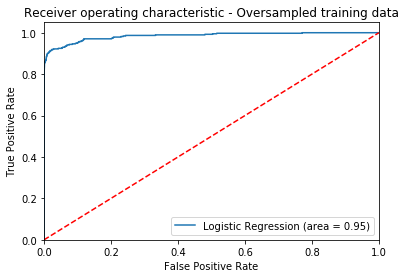

<Figure size 432x288 with 0 Axes>

In [19]:
logit_roc_auc = roc_auc_score(y_ros, clf_ros.predict(X_ros))
fpr, tpr, thresholds = roc_curve(y_ros, clf_ros.predict_proba(X_ros)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Oversampled training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

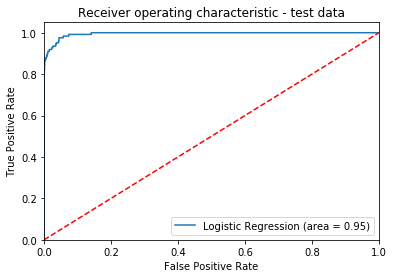

<Figure size 432x288 with 0 Axes>

In [20]:
logit_roc_auc = roc_auc_score(y_test, clf_ros.predict(X_test_standardized))
fpr, tpr, thresholds = roc_curve(y_test, clf_ros.predict_proba(X_test_standardized)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - test data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()


# Model3- SMOTETOMEK Oversampled data and validation on test data


In [21]:
clf_smt = LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio = 0.5, random_state=0).fit(X_smt, y_smt)
PREDICTIONS_smt_train = clf_smt.predict(X_smt)
PREDICTIONS_smt_test = clf_smt.predict(X_test_standardized)
print("The accuracy of the Logistic regression model on the SMOTE TOMEK Oversampled training data is :", clf_smt.score(X_smt, y_smt))
print("The accuracy of the Logistic regression model on the test data is :", clf_smt.score(X_test_standardized, y_test))

The accuracy of the Logistic regression model on the SMOTE TOMEK Oversampled training data is : 0.9418836406610516
The accuracy of the Logistic regression model on the test data is : 0.9753939496081571


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [22]:
cm_smt_train = metrics.confusion_matrix(y_smt, PREDICTIONS_smt_train)
print("The confusion matrix of training data is :", "\n", cm_smt_train)
cm_smt_test = metrics.confusion_matrix(y_test, PREDICTIONS_smt_test)
print("The confusion matrix of test data is :", "\n", cm_smt_test)

The confusion matrix of training data is : 
 [[208054   5182]
 [ 19603 193633]]
The confusion matrix of test data is : 
 [[69337  1742]
 [   10   113]]


In [23]:
print("The classification report on training data is \n")
print(classification_report(y_smt, PREDICTIONS_smt_train))
print("The classification report on test data is \n")
print(classification_report(y_test, PREDICTIONS_smt_test))

The classification report on training data is 

              precision    recall  f1-score   support

           0       0.91      0.98      0.94    213236
           1       0.97      0.91      0.94    213236

    accuracy                           0.94    426472
   macro avg       0.94      0.94      0.94    426472
weighted avg       0.94      0.94      0.94    426472

The classification report on test data is 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.06      0.92      0.11       123

    accuracy                           0.98     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.98      0.99     71202



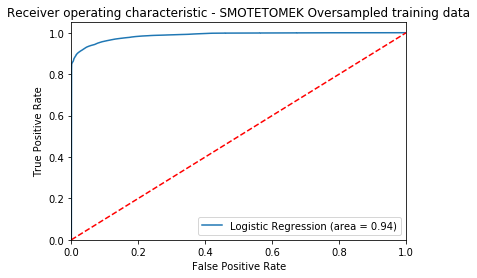

<Figure size 432x288 with 0 Axes>

In [24]:
logit_roc_auc = roc_auc_score(y_ros, clf_smt.predict(X_smt))
fpr, tpr, thresholds = roc_curve(y_ros, clf_smt.predict_proba(X_smt)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - SMOTETOMEK Oversampled training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()

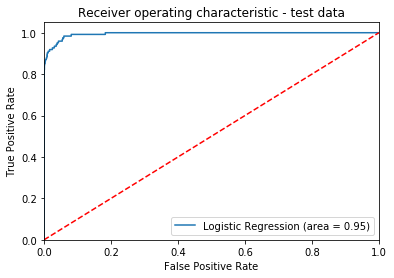

<Figure size 432x288 with 0 Axes>

In [25]:
logit_roc_auc = roc_auc_score(y_test, clf_smt.predict(X_test_standardized))
fpr, tpr, thresholds = roc_curve(y_test, clf_smt.predict_proba(X_test_standardized)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - test data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figure()
plt.show()


SMOTETOMEK oversampled data gave us the best results. So, I will use that data.

# 10 fold CV on whole data without sampling - This is an incorrect approach, but just to see

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

cv = StratifiedKFold(n_splits=10)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)
scaler = preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)

for fold, (train_index, test_index) in enumerate(cv.split(X_standardized,y),1):
    X_train = X_standardized[train_index]
    y_train = y[train_index] 
    X_test = X_standardized[test_index]
    y_test = y[test_index] 
    X_train_oversampled, y_train_oversampled = SMOTETomek(random_state = 1).fit_resample(X_train, y_train)
    model = LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio = 0.5, random_state=0)
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred)}')
    print(f'recall: {recall_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred)}')

C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 1:
Accuracy: 0.9764053228468101
f-score: 0.125
recall: 0.9795918367346939
precision: 0.06675938803894298


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 2:
Accuracy: 0.977599101155156
f-score: 0.08857142857142856
recall: 0.6326530612244898
precision: 0.047619047619047616


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 3:
Accuracy: 0.9768266563674028
f-score: 0.12928759894459102
recall: 1.0
precision: 0.0691114245416079


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 4:
Accuracy: 0.9869737719883431
f-score: 0.17371937639198218
recall: 0.7959183673469388
precision: 0.0975


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 5:
Accuracy: 0.9826551034022681
f-score: 0.1393728222996516
recall: 0.8163265306122449
precision: 0.0761904761904762


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 6:
Accuracy: 0.9529159790737685
f-score: 0.0642009769713887
recall: 0.92
precision: 0.033261026753434564


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 7:
Accuracy: 0.9589199817422142
f-score: 0.07582938388625592
recall: 0.96
precision: 0.039473684210526314


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 8:
Accuracy: 0.9706811797752809
f-score: 0.09534127843986999
recall: 0.8979591836734694
precision: 0.05034324942791762


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For fold 9:
Accuracy: 0.971875
f-score: 0.10302351623740202
recall: 0.9387755102040817
precision: 0.054502369668246446
For fold 10:
Accuracy: 0.9777387640449439
f-score: 0.11204481792717087
recall: 0.8163265306122449
precision: 0.06015037593984962


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The precision is very low

# The correct way of doing Cross Validation

In [ ]:
#initializing the validator
kf = StratifiedKFold(n_splits=10)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

scaler = preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)

def score_model(cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=10, shuffle = False)

    smoter = SMOTETomek(random_state=1)
    
    recalllscore = []
    precisionnscore = []
    accuracyy = []
    f1scoree = []

    for train_fold_index, val_fold_index in cv.split(X_standardized, y):
        # Get the training data
        X_train_fold, y_train_fold = X_standardized[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_standardized[val_fold_index], y[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold, y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = LogisticRegression(random_state = 0).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        recallscore = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        precisionscore = precision_score(y_val_fold, model_obj.predict(X_val_fold))
        accuracy = model_obj.score(X_val_fold, y_val_fold )
        f1score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        accuracyy.append(accuracy)
        f1scoree.append(f1score)
        recalllscore.append(recallscore)
        precisionnscore.append(precisionscore)
    return np.array(accuracyy), np.array(f1scoree), np.array(recalllscore), np.array(precisionnscore) 

# Example of the model in action
score_model(cv=kf)

Logistic Regression to see important variables

In [6]:
import statsmodels.formula.api as smf


In [4]:

data_train = pd.read_csv("SMOTE_TRAIN.csv")
data_test = pd.read_csv("test.csv")
print("The first 5 rows in the dataset are :", "\n", data_train.head())
print("\n")
print("The shape of the data is :", str(data_train.shape))
print("The shape of the data is :", str(data_test.shape))


The first 5 rows in the dataset are : 
       V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  ...    V21    V22    V23    V24    V25    V26    V27    V28  Amount  Class
0  0.011  0.672 -0.939 -0.346  0.737 -0.194  0.536  0.250 -0.456 -0.962  ...  0.451  1.243 -0.406 -2.384 -0.307 -0.188 -0.038  0.056  -0.201      0
1 -0.172  0.668  0.842  0.047 -0.018 -0.745  0.545 -0.034 -0.273 -0.454  ... -0.371 -1.020 -0.018  0.516 -0.347  0.155  0.595  0.299  -0.346      0
2 -0.127  0.499  0.125 -0.508  0.153 -0.617  0.617  0.069  0.177  0.106  ... -0.344 -0.844  0.179 -0.081 -1.081  0.275  0.842  0.438  -0.320      0
3 -0.020  0.353 -0.098 -0.417  0.744 -0.047  0.636 -0.005 -0.013 -0.327  ... -0.251 -0.699 -0.011 -2.006 -0.702 -1.115 -0.090  0.136  -0.316      0
4 -2.471  2.030 -2.061 -0.159 -1.545 -0.936 -1.129  1.885  0.135  0.184  ...  0.246 -0.416  0.829 -0.030 -1.701  0.060 -6.562 -1.719  -0.235      0

[5 rows x 30 columns]


The shape of the data is : (426472, 30)
The sha

In [5]:
data = pd.concat([data_train, data_test], ignore_index = True)
print(data.shape)

(497674, 30)


In [47]:
X = data_train.iloc[:,:-1].values
y = data_train.iloc[:,-1].values.reshape(-1)
X_test = data_test.iloc[:,:-1].values
y_test = data_test.iloc[:,-1].values.reshape(-1)

In [18]:

logreg1 = smf.logit('y ~ X', data).fit()

Optimization terminated successfully.
         Current function value: 0.139756
         Iterations 14


In [19]:
logreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               497674
Model:                          Logit   Df Residuals:                   497644
Method:                           MLE   Df Model:                           29
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.7954
Time:                        13:59:39   Log-Likelihood:                -69553.
converged:                       True   LL-Null:                   -3.3989e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5407      0.013   -262.565      0.000      -3.567      -3.514
X[0]           1.1721      0.034     34.174      0.000       1.105       1.239
X[1]           0.8051      0.052     15.460      0.000       0.703       0.907
X[2]           0.5558      0.021     26.097      0.000       0.514       0.598
X[3]           1.0491      0.013     79.842      0.000       1.023       1.075
X[4]           0.9185      0.031     29.508      0.000       0.858       0.980
X[5]          -0.6431      0.019    -33.629      0.000      -0.681      -0.606
X[6]          -0.5481      0.034    -15.992      0.000      -0.615      -0.481
X[7]          -0.4618      0.012    -38.875      0.000      -0.485      -0.439
X[8]          -0.3198      0.013    -25.012      0.000      -0.345      -0.295
X[9]          -0.9167      0.017    -52.417      0.000      -0.951      -0.882
X[10]          0.6320      0.010     60.557      0.000       0.612       0.652
X[11]         -0.9815      0.015    -65.145      0.000      -1.011      -0.952
X[12]         -0.2843      0.008    -37.186      0.000      -0.299      -0.269
X[13]         -1.3755      0.016    -83.407      0.000      -1.408      -1.343
X[14]          0.0677      0.008      8.957      0.000       0.053       0.083
X[15]         -0.5007      0.014    -35.331      0.000      -0.529      -0.473
X[16]         -0.7552      0.018    -41.878      0.000      -0.791      -0.720
X[17]         -0.2785      0.011    -24.752      0.000      -0.301      -0.256
X[18]          0.2185      0.010     22.751      0.000       0.200       0.237
X[19]         -0.4849      0.021    -22.723      0.000      -0.527      -0.443
X[20]         -0.0505      0.009     -5.392      0.000      -0.069      -0.032
X[21]          0.3262      0.010     31.178      0.000       0.306       0.347
X[22]          0.2908      0.017     17.264      0.000       0.258       0.324
X[23]          0.0503      0.009      5.650      0.000       0.033       0.068
X[24]          0.0395      0.009      4.421      0.000       0.022       0.057
X[25]         -0.1949      0.009    -22.332      0.000      -0.212      -0.178
X[26]          0.0230      0.011      2.139      0.032       0.002       0.044
X[27]          0.2144      0.012     18.422      0.000       0.192       0.237
X[28]          1.7269      0.076     22.800      0.000       1.578       1.875
==============================================================================

Possibly complete quasi-separation: A fraction 0.36 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [20]:
logreg1.pred_table()

array([[279238.,   5077.],
       [ 21275., 192084.]])

In [27]:
clf_smt = LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio = 0.5, random_state=0).fit(X, y)
PREDICTIONS_smt_train = clf_smt.predict(X)
PREDICTIONS_smt_test = clf_smt.predict(X_test)
print("The accuracy of the Logistic regression model on the SMOTE TOMEK Oversampled training data is :", clf_smt.score(X, y))
print("The accuracy of the Logistic regression model on the test data is :", clf_smt.score(X_test, y_test))

The accuracy of the Logistic regression model on the SMOTE TOMEK Oversampled training data is : 0.9418836406610516
The accuracy of the Logistic regression model on the test data is : 0.9753939496081571


C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Creating a dataset of the most important variables

In [39]:
clf_smt.coef_
columns = list(data_train.columns.values)
columns.remove('Class')
coef_df = pd.DataFrame(clf_smt.coef_, columns = columns)

In [43]:
coef_df.transpose()

,0
V1,0.851
V2,0.122
V3,0.323
V4,1.196
V5,0.566
V6,-0.450
V7,-0.111
V8,-0.599
V9,-0.368
V10,-1.015


In [46]:
#saving as a csv file
coef_df.transpose().to_csv("coef_df.csv")

In [49]:
from sklearn.feature_selection import f_classif
features = f_classif(X,y)

In [50]:
features

(array([9.01769582e+04, 1.49936732e+05, 1.94895878e+05, 4.26363035e+05,
        7.55719208e+04, 9.26432003e+04, 1.28926322e+05, 1.77114541e+03,
        2.02579697e+05, 2.88017698e+05, 4.13781115e+05, 3.66331766e+05,
        1.24637314e+03, 5.98819181e+05, 2.18871820e+02, 2.34157747e+05,
        1.94768765e+05, 1.21626135e+05, 3.52858526e+04, 1.56903020e+04,
        7.99292152e+03, 5.17418422e+01, 1.31436062e+02, 2.83301711e+03,
        2.40453475e+03, 1.64727960e+03, 3.48186608e+03, 4.82565217e+03,
        2.43063665e+02]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.26657577e-272, 0.00000000e+000, 1.63973658e-049, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 6.34025099e-013, 2.00828216e-030, 0.00000000e+000,
        0.0000

In [109]:
#outlier detection - correlation.
#Take only the PCA variables
data_V = data.iloc[:, 0:28]
data_V.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [113]:
#Create the correlation matrix
correlation_martix = data_V.corr().round(2)

In [112]:
data.corr().round(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.0,0.00,0.00,-0.23,-0.10
V2,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.0,-0.00,-0.00,-0.53,0.09
V3,-0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,-0.00,0.00,0.0,0.00,0.00,-0.21,-0.19
V4,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.0,-0.00,-0.00,0.10,0.13
V5,0.00,-0.00,-0.00,-0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,...,-0.00,0.00,0.00,-0.00,0.00,0.0,0.00,-0.00,-0.39,-0.09
V6,0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.00,0.00,-0.0,-0.00,0.00,0.22,-0.04
V7,0.00,0.00,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,...,0.00,-0.00,0.00,-0.00,0.00,-0.0,-0.00,-0.00,0.40,-0.19
V8,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,...,-0.00,0.00,0.00,-0.00,-0.00,-0.0,0.00,-0.00,-0.10,0.02
V9,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,...,0.00,0.00,0.00,-0.00,0.00,-0.0,-0.00,0.00,-0.04,-0.10
V10,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,1.00,...,0.00,-0.00,0.00,-0.00,-0.00,-0.0,-0.00,-0.00,-0.10,-0.22


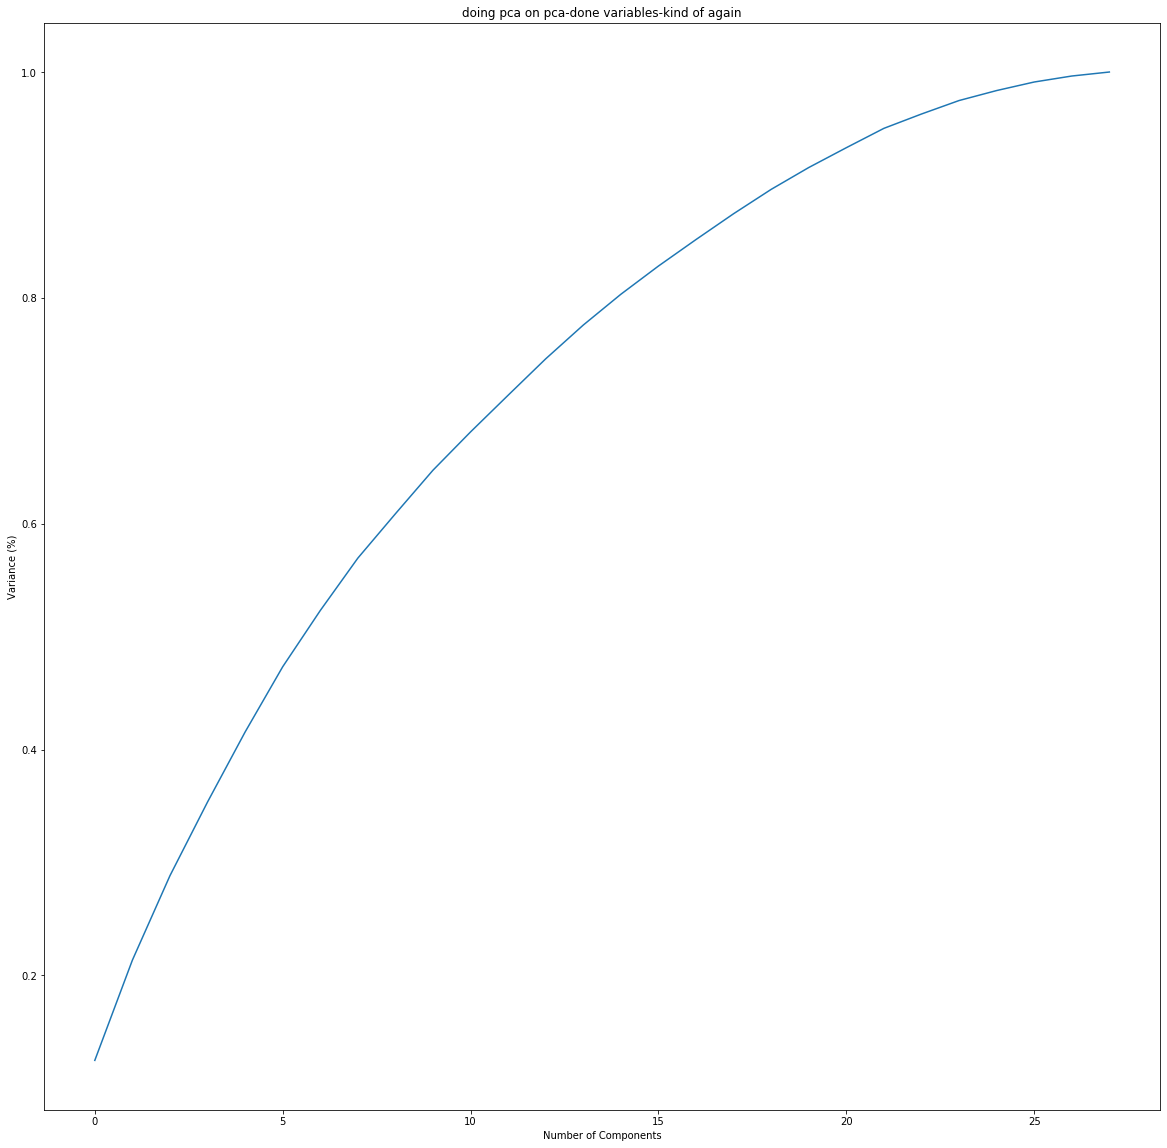

In [125]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_V)
#Plotting the Cumulative Summation of the Explained Variance

plt.figure(figsize=(20,20))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('doing pca on pca-done variables-kind of again')
plt.show()